In [1258]:
!pip install datasetsforecast

In [1259]:
import pprint
import datasetsforecast

In [1260]:
help(datasetsforecast)

Help on package datasetsforecast:

NAME
    datasetsforecast

PACKAGE CONTENTS
    _modidx
    _nbdev
    evaluation
    hierarchical
    long_horizon
    losses
    m3
    m4
    m5
    utils

VERSION
    0.0.8

FILE
    /usr/local/lib/python3.10/dist-packages/datasetsforecast/__init__.py




In [1261]:
from datasetsforecast import long_horizon, m3, m4, m5

In [1262]:
help(long_horizon)

Help on module datasetsforecast.long_horizon in datasetsforecast:

NAME
    datasetsforecast.long_horizon - # AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/long_horizon.ipynb.

CLASSES
    builtins.object
        ECL
        ETTh1
        ETTh2
        ETTm1
        ETTm2
        Exchange
        ILI
        LongHorizon
        TrafficL
        Weather
    
    class ECL(builtins.object)
     |  ECL(freq: str = '15T', name: str = 'ECL', n_ts: int = 321, test_size: int = 5260, val_size: int = 2632, horizons: Tuple[int] = (96, 192, 336, 720)) -> None
     |  
     |  The Electricity dataset reports the fifteen minute electricity 
     |  consumption (KWh) of 321 customers from 2012 to 2014. 
     |  For comparability, we aggregate it hourly.
     |  
     |      Reference:
     |      Li, S et al. Enhancing the locality and breaking the memory 
     |      bottleneck of Transformer on time series forecasting.
     |      NeurIPS 2019. http://arxiv.org/abs/1907.00235.
     |  
     |  

In [1263]:
help(long_horizon.LongHorizon)

Help on class LongHorizon in module datasetsforecast.long_horizon:

class LongHorizon(builtins.object)
 |  LongHorizon(source_url: str = 'https://nhits-experiments.s3.amazonaws.com/datasets.zip') -> None
 |  
 |  This Long-Horizon datasets wrapper class, provides
 |  with utility to download and wrangle the following datasets:    
 |  ETT, ECL, Exchange, Traffic, ILI and Weather.
 |  
 |  - Each set is normalized with the train data mean and standard deviation.
 |  - Datasets are partitioned into train, validation and test splits.
 |  - For all datasets: 70%, 10%, and 20% of observations are train, validation, test, 
 |    except ETT that uses 20% validation.
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __init__(self, source_url: str = 'https://nhits-experiments.s3.amazonaws.com/datasets.zip') -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  ----

In [1264]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import DataLoader, TensorDataset

In [1265]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Fri Aug 16 22:48:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              50W / 400W |   1755MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [1266]:
'''
NXLong horizon datasets:

'ETTh1', 'ETTh2',
'ETTm1', 'ETTm2',
'ECL', 'Exchange',
'TrafficL', 'Weather', 'ILI'.
'''

# Nixtla Forecast Datasets
# Exchange - good
# ECL - bad
# ETTh1 - good
# ETTh2 - good
# ETTm1 - good
# ETTm2 - good
# TrafficL - bad
# Weather - good
# ILI - bad

DATASET = 'ETTm1'
data_tuple = long_horizon.LongHorizon.load("./", DATASET, True)

# data_tuple = long_horizon.LongHorizon.load("./", 'ETTh1', True)
# data_tuple = long_horizon.LongHorizon.load("./", 'ETTh2', True)
# data_tuple = long_horizon.LongHorizon.load("./", 'ETTm1', True)
# data_tuple = long_horizon.LongHorizon.load("./", 'ETTm2', True)
# data_tuple = long_horizon.LongHorizon.load("./", 'Exchange', True)
# data_tuple = long_horizon.LongHorizon.load("./", 'ECL', True)

en, ex, _ = data_tuple # endogenous variable and exogenous

In [1267]:
# tsdata = pd.concat([ex, en.drop(columns=['ds', 'unique_id'])], axis=1)
# uniques = np.unique(tsdata[["unique_id"]].values)
# print(uniques)
# for unique in uniques:
#   series = tsdata[tsdata["unique_id"] == unique]
#   print(len(series))
#   print(series.head())

uniques = np.unique(en[["unique_id"]].values)
print(uniques)
# for unique in uniques:
#   variable = en[en["unique_id"] == unique]
#   print(len(variable))
#   print(variable.head())

data = en.pivot(index='ds', columns='unique_id', values='y')
data.columns.name = None  # Remove the automatic naming of the 'unique_id' dimension
data = data.rename_axis(None, axis=1)  # Remove the name for the columns index

print(data.head())

['HUFL' 'HULL' 'LUFL' 'LULL' 'MUFL' 'MULL' 'OT']
                         HUFL      HULL      LUFL      LULL      MUFL  \
ds                                                                      
2016-07-01 00:00:00 -0.370818 -0.014236  1.343801  0.867770 -0.636148   
2016-07-01 00:15:00 -0.382304  0.017827  1.402424  0.964221 -0.655535   
2016-07-01 00:30:00 -0.382304 -0.046299  1.373593  0.820334 -0.655535   
2016-07-01 00:45:00 -0.382304 -0.046299  1.373593  0.820334 -0.655535   
2016-07-01 01:00:00 -0.393790  0.017827  1.285179  0.916786 -0.655535   

                        MULL        OT  
ds                                      
2016-07-01 00:00:00 -0.15291  1.461463  
2016-07-01 00:15:00 -0.17162  1.453723  
2016-07-01 00:30:00 -0.18981  1.407718  
2016-07-01 00:45:00 -0.17162  1.077947  
2016-07-01 01:00:00 -0.17162  1.162325  


In [1268]:
import yfinance as yf
# import pandas as pd

# Define the ticker symbol for Apple
ticker_symbol = 'AAPL'

# Fetch historical market data for the last 5 years
data = yf.download(ticker_symbol, period="5y")
print("\n")

# Display the first few rows of the data
# data.reset_index(inplace=True)
data = (data-data.mean())/data.std()

data = 2 * (data - data.min()) / (data.max() - data.min()) - 1
print(data.head())


column_names = data.columns

uniques = [col for col in column_names]

print(uniques)

[*********************100%%**********************]  1 of 1 completed



                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2019-08-19 -0.982422 -0.981136 -0.975306 -0.979067  -0.979894 -0.634221
2019-08-20 -0.981721 -0.979467 -0.974513 -0.979040  -0.979868 -0.585109
2019-08-21 -0.976032 -0.978660 -0.971013 -0.972850  -0.973922 -0.691433
2019-08-22 -0.975493 -0.976534 -0.973337 -0.973338  -0.974391 -0.677154
2019-08-23 -0.985630 -0.982966 -1.000000 -1.000000  -1.000000 -0.188873
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [1269]:

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out


In [1270]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        # Custom weight initialization
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # layer x batch x hidden_size
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # layer x batch x hidden_size

        out, _ = self.lstm(x, (h0, c0))
        # print(out.shape)
        out = self.fc(out[:, -1, :])
        # print(out.shape)
        return out



In [1271]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=0, dilation=dilation)

    def forward(self, x):
        # x = F.pad(x, (self.padding, 0))
        return self.conv(F.pad(x, (self.padding, 0)))


class TemporalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout=0.2):
        super(TemporalConvBlock, self).__init__()
        # padding = (kernel_size - 1) * dilation
        # self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        # self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.conv1 = CausalConv1d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation)
        self.conv2 = CausalConv1d(out_channels, out_channels, kernel_size, stride=stride, dilation=dilation)
        self.dropout = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, nn.ReLU(), self.dropout, self.conv2, nn.ReLU(), self.dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        # print("TCN Block Iteration\n")
        # print("x shape: ", x.shape)
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        # print("Out shape: ", out.shape)
        # print("Res shape: ", res.shape)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalConvBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCNModel(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        # print("TCN Model \n")
        # print("x shape: ", x.shape)
        x = x.transpose(1, 2) # B x T x F -> B x F x T
        # conv1d needs B x F x T in order to convolve across time
        y1 = self.tcn(x)
        o = self.linear(y1[:, :, -1]) # selects last timestep
        return o



In [1272]:
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / model_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [1273]:
!git clone https://github.com/Blealtan/efficient-kan.git
!cd efficient-kan && pip install .

fatal: destination path 'efficient-kan' already exists and is not an empty directory.
Processing /content/efficient-kan
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for efficient-kan: filename=efficient_kan-0.1.0-py3-none-any.whl size=5732 sha256=3ef1a2ecc035552022ca1dbb071a4d2df50f59173e279c345e9b8afd624d4270
  Stored in directory: /root/.cache/pip/wheels/03/9e/5e/a67dcdc4f819da270f0f599858798db09ad810c415559d3aea
Successfully built efficient-kan
  Attempting uninstall: efficient-kan
    Found existing installation: efficient-kan 0.1.0
    Uninstalling efficient-kan-0.1.0:
      Successfully uninstalled efficient-kan-0.1.0


In [1274]:
!cd efficient-kan
from efficient_kan import KAN, KANLinear

In [1275]:
class KANConv1d(nn.Module):
    def __init__(self, sequence_length, in_features, out_features, kernel_size=3, grid_size=5, spline_order=3, padding=0, dilation=1, stride=1,
            base_activation=torch.nn.SiLU,
            grid_range=[-1, 1], causal=False
        ):

        super(KANConv1d, self).__init__()

        self.sequence_length = sequence_length
        self.kernel_size = kernel_size
        self.dilation = dilation
        # self.padding = (kernel_size - 1) * dilation
        self.padding = padding

        self.grid_size = grid_size
        self.spline_order = spline_order

        self.stride=stride

        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .unsqueeze(1)  # Add a dimension for sequence_length
            .expand(in_features, sequence_length, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        # no stand alone scale spline


        # m = grid_size + 2*spline_order + 1 is length of knot vector, our number of bases is given by n = m-spline_order-1
        # number of bases n = grid_size + spline_order

        self.causal = causal

        if self.causal:
            self.padding = 0

        self.base_conv = nn.Conv1d(in_features, out_features, kernel_size, dilation=dilation, padding=self.padding, stride=self.stride)
        self.spline_conv = nn.Conv1d( (self.grid_size + self.spline_order) * in_features, out_features, kernel_size, dilation=dilation, padding=self.padding, stride=self.stride)

        nn.init.kaiming_uniform_(self.base_conv.weight, nonlinearity='linear')
        nn.init.kaiming_uniform_(self.spline_conv.weight, nonlinearity='linear')


        self.base_activation = base_activation()


    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features, sequence_length).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, sequence_length, grid_size + spline_order).
        """
        assert x.dim() == 3 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)

        # bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        bases = ((x >= grid[..., :-1]) & (x < grid[..., 1:])).to(x.dtype)
        # print(bases.shape)
        # print(grid.shape)

        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[..., : -(k + 1)])
                / (grid[..., k:-1] - grid[..., : -(k + 1)])
                * bases[..., :-1]
            ) + (
                (grid[..., k + 1 :] - x)
                / (grid[..., k + 1 :] - grid[..., 1:(-k)])
                * bases[..., 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.sequence_length,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()


    def forward(self, x: torch.Tensor): # FORWARD
        # print("x shape: ", x.shape)

        # Expects B x F x T
        # x = x.transpose(1, 2) # B x T x F -> B x F x T
        # print("x shape: ", x.shape)

        assert x.size(1) == self.in_features
        original_shape = x.shape

        base_act = self.base_activation(x)

        padded_base_act = F.pad(base_act, ((self.kernel_size-1)*self.dilation, 0))
        # print("Padded x shape: ", padded_x.shape)
        base_input = padded_base_act if self.causal else base_act

        base_output = self.base_conv(base_input)

        # print("B-Spline shape: ", self.b_splines(x).shape)
        # print("B-Spline View shape: ", self.b_splines(x).view(x.size(0), self.in_features, -1).shape)
        # print("Spline Weight shape: ", self.spline_conv.weight.shape)
        # print("Spline Weight View shape: ", self.spline_conv.weight.view(self.out_features, self.in_features, -1).shape)

        '''
        B-Spline shape:  torch.Size([32, 7, 5, 8])
        B-Spline View shape:  torch.Size([32, 7, 40])
        Spline Weight shape:  torch.Size([64, 7, 3, 8])
        Spline Weight View shape:  torch.Size([64, 7, 24])
        '''



        spline_bases = self.b_splines(x).view(x.size(0), self.in_features * (self.grid_size + self.spline_order), -1)
        spline_bases_padded = F.pad(spline_bases, ((self.kernel_size-1)*self.dilation, 0))

        spline_input = spline_bases_padded if self.causal else spline_bases

        spline_output = self.spline_conv(spline_input)

        output = base_output + spline_output # B x F x T
        # print("Output shape: ", output.shape) # torch.Size([32, 64, 5])
        # output = output.transpose(1, 2)
        # print("Output shape: ", output.shape)
        return output

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_conv.weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )



In [1276]:
class FeaturesLayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(FeaturesLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape)

    def forward(self, x):
        x = x.transpose(1, 2) # B x F x T -> B x T x F
        x = self.layer_norm(x)
        return x.transpose(1, 2) # B x T x F -> B x F x T

class TemporalKANConvBlock(nn.Module):
    def __init__(self, sequence_length, in_channels, out_channels, kernel_size, stride, dilation, dropout=0.2):
        super(TemporalKANConvBlock, self).__init__()
        # padding = (kernel_size - 1) * dilation
        # self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        # self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.conv1 = KANConv1d(sequence_length, in_channels, out_channels, kernel_size, stride=stride, dilation=dilation, causal=True)
        self.conv2 = KANConv1d(sequence_length, out_channels, out_channels, kernel_size, stride=stride, dilation=dilation, causal=True)
        self.layer_norm = FeaturesLayerNorm(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.layer_norm, self.dropout, self.conv2, self.layer_norm, self.dropout)
        #up/downsampling - sends in_channels into ka function, sums them, does this operation seperately out channel times
        self.downsample = KANConv1d(sequence_length, in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None
        # self.relu = nn.ReLU()

    def forward(self, x):
        # print("TCN Block Iteration\n")
        # print("x shape: ", x.shape)
        out = self.net(x)
        res = x if self.downsample is None else self.layer_norm(self.downsample(x))
        # print("Out shape: ", out.shape)
        # print("Res shape: ", res.shape)
        return out + res



class TemporalKANConvNet(nn.Module):
    def __init__(self, sequence_length, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalKANConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalKANConvBlock(sequence_length, in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TCKAN(nn.Module):
    def __init__(self, sequence_length, input_size, output_size, num_channels, kernel_size=2, dropout=0.2):
        super(TCKAN, self).__init__()

        self.tcn = TemporalKANConvNet(sequence_length, input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = KANLinear(num_channels[-1], output_size)

    def forward(self, x):
        # print("TCN Model \n")
        # print("x shape: ", x.shape)
        x = x.transpose(1, 2) # B x T x F -> B x F x T
        # conv1d needs B x F x T in order to convolve across time
        y1 = self.tcn(x)
        o = self.linear(y1[:, :, -1]) # selects last timestep
        return o



In [1277]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size = x.size(0)

        # Linear projections for query, key, and value
        Q = self.q_linear(x)  # [batch_size, seq_len, d_model]
        K = self.k_linear(x)  # [batch_size, seq_len, d_model]
        V = self.v_linear(x)  # [batch_size, seq_len, d_model]

        # Split into multiple heads and then reshape to perform scaled dot-product attention
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)  # [batch_size, num_heads, seq_len, d_k]

        # Concatenate heads and pass through the final linear layer
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        output = self.out_linear(attn_output)  # [batch_size, seq_len, d_model]

        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout=0.1):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, dim_feedforward)
        self.fc2 = nn.Linear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward=128, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, dim_feedforward, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # Self-attention layer with residual connection and layer normalization
        attn_output = self.self_attn(src)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        # Feed-forward layer with residual connection and layer normalization
        ff_output = self.feed_forward(src)
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)

        return src



# Encoder-Only Transformer Model
class TransformerTimeSeriesModel(nn.Module):
    def __init__(self, input_size, output_size, d_model=128, num_heads=8, num_encoder_layers=4, dim_feedforward=128, dropout=0.1):
        super(TransformerTimeSeriesModel, self).__init__()

        self.d_model = d_model
        self.input_embedding = nn.Linear(input_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        # Stack of custom encoder layers
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(d_model, num_heads, dim_feedforward, dropout) for _ in range(num_encoder_layers)])

        # Final output projection
        self.fc_out = nn.Linear(d_model, output_size)

    def forward(self, src):
        # Embed the input sequence and add positional encoding
        src = self.input_embedding(src) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        src = self.positional_encoding(src)

        # Pass through the stack of encoder layers
        for encoder_layer in self.encoder_layers:
            src = encoder_layer(src)

        # Final output projection to the desired output size
        output = self.fc_out(src[:, -1, :])  # Use the last time step's encoded state for prediction

        return output

In [1278]:
class KANMultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(KANMultiHeadSelfAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.q_linear = KANLinear(d_model, d_model)
        self.k_linear = KANLinear(d_model, d_model)
        self.v_linear = KANLinear(d_model, d_model)
        self.out_linear = KANLinear(d_model, d_model)

    def forward(self, x):
        batch_size = x.size(0)

        # Linear projections for query, key, and value
        Q = self.q_linear(x)  # [batch_size, seq_len, d_model]
        K = self.k_linear(x)  # [batch_size, seq_len, d_model]
        V = self.v_linear(x)  # [batch_size, seq_len, d_model]

        # Split into multiple heads and then reshape to perform scaled dot-product attention
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)  # [batch_size, num_heads, seq_len, d_k]

        # Concatenate heads and pass through the final linear layer
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        output = self.out_linear(attn_output)  # [batch_size, seq_len, d_model]

        return output

class KANFeedForward(nn.Module):
    def __init__(self, d_model, dim_feedforward=128, dropout=0.1):
        super(KANFeedForward, self).__init__()
        self.fc1 = KANLinear(d_model, dim_feedforward)
        self.fc2 = KANLinear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

class KANTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward, dropout=0.1):
        super(KANTransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, dim_feedforward, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # Self-attention layer with residual connection and layer normalization
        attn_output = self.self_attn(src)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        # Feed-forward layer with residual connection and layer normalization
        ff_output = self.feed_forward(src)
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)

        return src



# Encoder-Only Transformer Model
class KANTransformerTimeSeriesModel(nn.Module):
    def __init__(self, input_size, output_size, d_model=128, num_heads=8, num_encoder_layers=4, dim_feedforward=128, dropout=0.1):
        super(KANTransformerTimeSeriesModel, self).__init__()

        self.d_model = d_model
        self.input_embedding = KANLinear(input_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        # Stack of custom encoder layers
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(d_model, num_heads, dim_feedforward, dropout) for _ in range(num_encoder_layers)])

        # Final output projection
        self.fc_out = KANLinear(d_model, output_size)

    def forward(self, src):
        # Embed the input sequence and add positional encoding
        src = self.input_embedding(src) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        src = self.positional_encoding(src)

        # Pass through the stack of encoder layers
        for encoder_layer in self.encoder_layers:
            src = encoder_layer(src)

        # Final output projection to the desired output size
        output = self.fc_out(src[:, -1, :])  # Use the last time step's encoded state for prediction

        return output


In [1279]:
class EarlyStopping:
    def __init__(self, patience=50, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [1280]:


# X = torch.tensor(data[["ex_1", "ex_2", "ex_3", "ex_4", "y"]].values, dtype=torch.float32) # features
# y = torch.tensor(data[["y"]].values, dtype=torch.float32) # target

# ALL EXCEPT STOCK
# TARGET = uniques[-1]
# AAPL STOCK
TARGET = uniques[3]

X = torch.tensor(data[uniques].values, dtype=torch.float32) # features
y = torch.tensor(data[TARGET].values, dtype=torch.float32) # target

# FORECAST LENGTHS: 1, 12, 24, 48

SEQUENCE_LENGTH = 48

FORECAST_LENGTH = 1

VARIATES = X.shape[1]
print(VARIATES)

class print_shape(nn.Module):
  def __init__(self):
    super(print_shape, self).__init__()

  def forward(self, x):
    print(x.shape)
    return x

# model = LSTMModel(VARIATES, 128, FORECAST_LENGTH, 2) #
# model = MLP(VARIATES*SEQUENCE_LENGTH, 256, FORECAST_LENGTH)
# model = TCNModel(VARIATES, FORECAST_LENGTH, [256, 128, 128], kernel_size=2, dropout=0.2)
# model = TransformerTimeSeriesModel(VARIATES, FORECAST_LENGTH)

# model = nn.Sequential(nn.Flatten(), KAN([VARIATES*SEQUENCE_LENGTH, 256, 256, FORECAST_LENGTH]))

model = TCKAN(SEQUENCE_LENGTH, VARIATES, FORECAST_LENGTH, [256, 128, 128], kernel_size=2, dropout=0.2)
# model = KANTransformerTimeSeriesModel(VARIATES, FORECAST_LENGTH)


model = model.to(device)
# -----------------------------------------------------------------------------------------------------
# Create Sequences
#
# Single Target Forecast: [ex_t-p+1, …, ex_t] and [y_t-p+1, …, y_t] to predict y_t+1
#
# Multi Target Forecast: [ex_t-p+1, …, ex_t] and [y_t-p+1, …, y_t+f-1] to predict [y_t+1, …, y_t+f]
#
# -----------------------------------------------------------------------------------------------------


# def create_sequences(X, y, seq_length=SEQUENCE_LENGTH, forecast_length=FORECAST_LENGTH): # SINGLE TARGET, SINGLE STEP FORECAST
#     xs, ys = [], []
#     for i in range(seq_length, len(X)-forecast_length):
#         xs.append(X[i-seq_length+1: i+1])
#         ys.append(y[i+1])
#     return torch.stack(xs), torch.stack(ys)

def create_sequences(X, y, seq_length=SEQUENCE_LENGTH, forecast_length=FORECAST_LENGTH): # SINGLE TARGET, MULTI STEP FORECAST
    xs, ys = [], []
    for i in range(seq_length, len(X)-forecast_length):
        xs.append(X[i-seq_length+1: i+1])
        ys.append(y[i+1 : i+forecast_length+1])
    return torch.stack(xs), torch.stack(ys)

# Apply function to create sequences
X_seq, y_seq = create_sequences(X, y, SEQUENCE_LENGTH, FORECAST_LENGTH)

print(X_seq.shape)
print(y_seq.shape)

# # Check shapes
# print("Shape of X_seq:", X_seq.shape)  # (num_samples, seq_length, num_features)
# print("Shape of y_seq:", y_seq.shape)  # (num_samples, 1)

# # Example output
# print("X_seq:", X_seq[:2])  # Print first 2 sequences
# print("y_seq:", y_seq[:2])  # Print corresponding y values

# print("X:", X[seq_length:seq_length+2])
# print("y:", y[seq_length:seq_length+2])

# Time series split hyperparams from Nixtla
# test_size = getattr(long_horizon, DATASET).test_size
# val_size = getattr(long_horizon, DATASET).val_size
# train_size = len(X_seq) - test_size - val_size

# print(test_size/len(X_seq))
# print(val_size/len(X_seq))
# print(train_size/len(X_seq))

# Time series split 0.7:0.15:0.15
train_size = int(0.7 * len(X_seq))
val_size = int(0.15 * len(X_seq))
test_size = len(X_seq) - train_size - val_size

X_train = X_seq[:train_size]
X_val = X_seq[train_size:train_size + val_size]
X_test = X_seq[train_size + val_size:]

y_train = y_seq[:train_size]
y_val = y_seq[train_size:train_size + val_size]
y_test = y_seq[train_size + val_size:]



6
torch.Size([1209, 48, 6])
torch.Size([1209, 1])


In [1281]:
print("Shapes of splits:")
print(X_seq.shape,y_seq.shape)
print("\n")
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

Shapes of splits:
torch.Size([1209, 48, 6]) torch.Size([1209, 1])


torch.Size([846, 48, 6]) torch.Size([846, 1])
torch.Size([181, 48, 6]) torch.Size([181, 1])
torch.Size([182, 48, 6]) torch.Size([182, 1])


In [1282]:
def mape(y_true, y_pred):
    # y_true = y_true.float()
    # y_pred = y_pred.float()

    percentage_error = torch.abs((y_true - y_pred) / y_true)

    mape_value = torch.mean(percentage_error) * 100

    return mape_value

In [1283]:


train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

LEARNING_RATE = 1e-3

early_stopping = EarlyStopping(patience=100, verbose=False)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce learning rate by a factor of 0.1 every 10 epochs
criterion = nn.MSELoss()

train_losses = []
val_losses = []

# Training loop
epochs = 100

for epoch in range(epochs):
  model.train()
  train_loss = 0.0

  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  # Validation loop
  model.eval()
  val_loss = 0.0

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(val_loader):
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = criterion(output, target)
      val_loss += loss.item()

  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  early_stopping(val_loss, model)

  if early_stopping.early_stop:
    print("Early stopping")
    break



  print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 1/100, Train Loss: 0.6150, Val Loss: 0.2949
Epoch 2/100, Train Loss: 0.0647, Val Loss: 0.1060
Epoch 3/100, Train Loss: 0.0694, Val Loss: 0.3280
Epoch 4/100, Train Loss: 0.1158, Val Loss: 0.2737
Epoch 5/100, Train Loss: 0.0669, Val Loss: 0.4667
Epoch 6/100, Train Loss: 0.1540, Val Loss: 0.0166
Epoch 7/100, Train Loss: 0.1214, Val Loss: 0.0149
Epoch 8/100, Train Loss: 0.0611, Val Loss: 0.0058
Epoch 9/100, Train Loss: 0.0449, Val Loss: 0.0170
Epoch 10/100, Train Loss: 0.0668, Val Loss: 0.0788
Epoch 11/100, Train Loss: 0.0381, Val Loss: 0.0434
Epoch 12/100, Train Loss: 0.0446, Val Loss: 0.0044
Epoch 13/100, Train Loss: 0.0141, Val Loss: 0.0065
Epoch 14/100, Train Loss: 0.0124, Val Loss: 0.0740
Epoch 15/100, Train Loss: 0.0228, Val Loss: 0.0179
Epoch 16/100, Train Loss: 0.0136, Val Loss: 0.0082
Epoch 17/100, Train Loss: 0.0251, Val Loss: 0.0248
Epoch 18/100, Train Loss: 0.0178, Val Loss: 0.0352
Epoch 19/100, Train Loss: 0.0136, Val Loss: 0.0105
Epoch 20/100, Train Loss: 0.0061, Val Lo

<All keys matched successfully>

In [1284]:
# Test loop
model.eval()
test_loss = 0.0

predictions = []

with torch.no_grad():
  for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)

    predictions.append(output.cpu().numpy())
    # print("Prediction:")
    # print(output.numpy())
    # print("Prediction shape:")
    # print(output.numpy().shape)
    loss = criterion(output, target)
    test_loss += loss.item()

test_loss /= len(test_loader)

predictions = np.concatenate(predictions, axis=0)
mean_absolute_percentage_error = mape(y_test, predictions)
print(f"Test Loss: {test_loss:.4f}")
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error:.4f}")
# print("Predictions:")
# print(predictions)
# print("Predictions shape:")
# print(predictions.shape)
# print(len(y_test))

print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0325
Mean Absolute Percentage Error: 18.6558
Test Loss: 0.0325


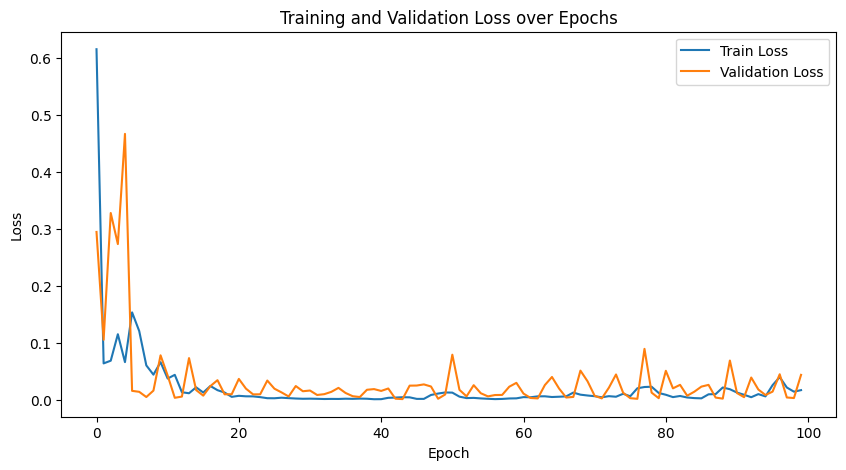

In [1285]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

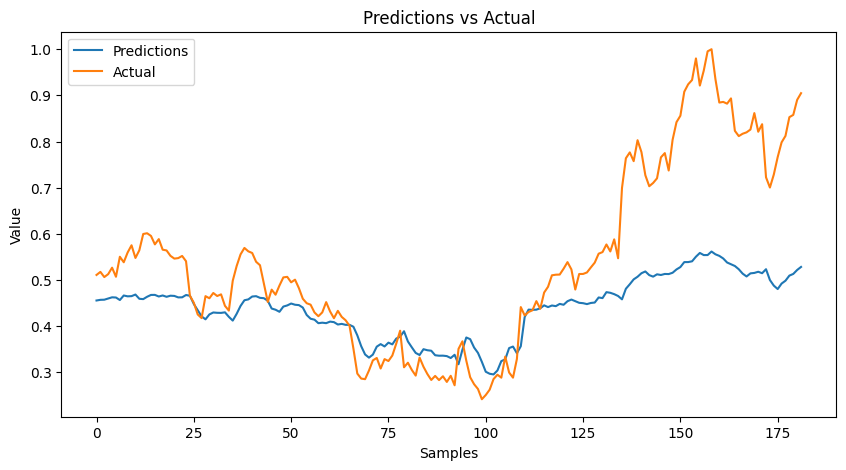

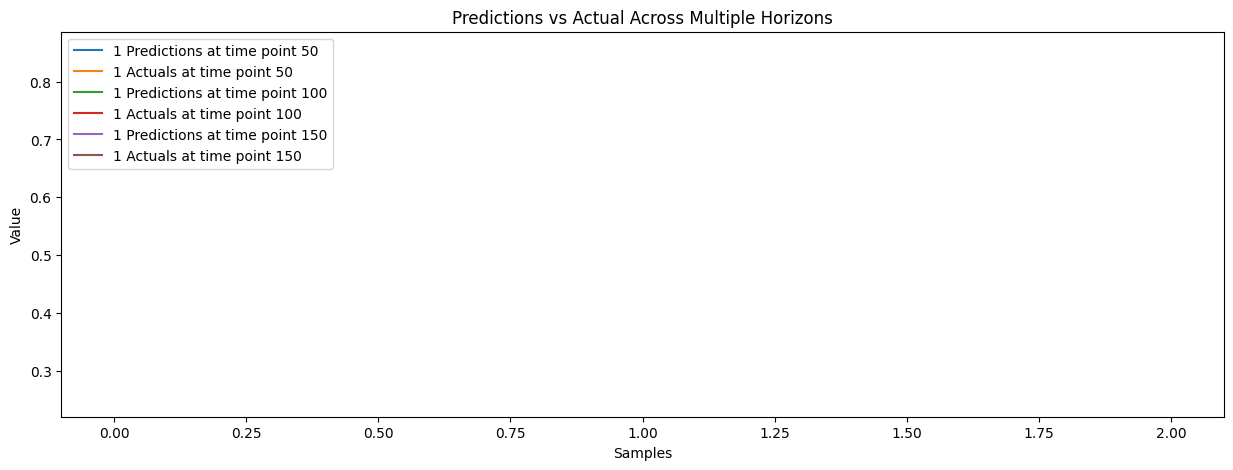

In [1286]:
plt.figure(figsize=(10, 5))
plt.plot(predictions[:,0], label='Predictions')
plt.plot(y_test[:,0], label='Actual')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.title('Predictions vs Actual')
plt.legend()
plt.show()


# plt.plot(y_seq.numpy(), label='Whole')
# plt.xlabel('Samples')
# plt.ylabel('Value')
# plt.title('Actual')
# plt.legend()
# plt.show()

# points to visualize the forecasts
time_points = [50, 100, 150]  # Example time points
horizon_length = predictions.shape[1]

plt.figure(figsize=(15, 5))

# Loop through the selected time points and plot them on the same graph
for i, time_point in enumerate(time_points):
    plt.plot(range(i*horizon_length, (i+1)*horizon_length), predictions[time_point], label=f'{horizon_length} Predictions at time point {time_point}')
    plt.plot(range(i*horizon_length, (i+1)*horizon_length), y_test[time_point], label=f'{horizon_length} Actuals at time point {time_point}')

plt.xlabel('Samples')
plt.ylabel('Value')
plt.title('Predictions vs Actual Across Multiple Horizons')
plt.legend()
plt.show()